In [10]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('../report_plots/report.mplstyle')

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')

import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


# Figure 15

In [2]:
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

dataset_dict = HDC.get_synthetic_data('synthetic_negbinomial', data_dir)

model_dict = {
                'seed': 123, 
                'll_mode': 'U-eq-2',  # stands for universal count model with exponential-quadratic expansion and C = 2
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }

checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run=-1

modelfit, training_results, fit_set, validation_set = lib.models.load_model(
                    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
                    delay, cv_run, batch_size, gpu_dev
                )

In [3]:
neurons = dataset_dict['neurons']

hd_sweep = torch.linspace(0, 2*np.pi, 100)

covariates = hd_sweep[None, None, :, None]

with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(neurons)), MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

print(P_mc.shape)

K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

[tc_mean_lower, tc_mean, tc_mean_upper] = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
[tc_FF_lower, tc_FF, tc_FF_upper] = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])
[tc_var_lower, tc_var, tc_var_upper] = utils.signal.percentiles_from_samples(hd_var, [0.05, 0.5, 0.95])

grad = torch.gradient(torch.nan_to_num(torch.log(P_mc), neginf=0.0), dim=2)
grad = grad[0]

[fisher_lower, fisher, fisher_upper] = utils.signal.percentiles_from_samples((grad**2 * P_mc).sum(-1), [0.05, 0.5, 0.95])

[fisher_poisson_lower, fisher_poisson, fisher_poisson_upper] = utils.signal.percentiles_from_samples(torch.gradient(hd_rate, dim=2)[0]**2/  hd_rate, [0.05, 0.5, 0.95])
fisher_poisson  *= dataset_dict['tbin']
fisher_poisson_lower  *= dataset_dict['tbin']
fisher_poisson_upper  *= dataset_dict['tbin']


torch.Size([30, 5, 100, 291])


In [4]:
mouse_id = 'Mouse12'
session_id = 120806
phase = 'wake'
subset = 'hdc'

bin_size = 160  # ms
single_spikes = False

delay = 0
batch_size = 600  # size of time segments of each batch in dataset below
cv_run = -1


checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'


dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

model_dict = {
                'seed': 123, 
                'll_mode': 'U-eq-2',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }

hd_sweep = torch.linspace(0, 2*np.pi, 100)
angles = np.linspace(0, 360, hd_sweep.shape[-1])

modelfit, training_results, fit_set, validation_set = lib.models.load_model(
        checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
        delay, cv_run, batch_size, gpu_dev)

units:  85  hdc units:  22


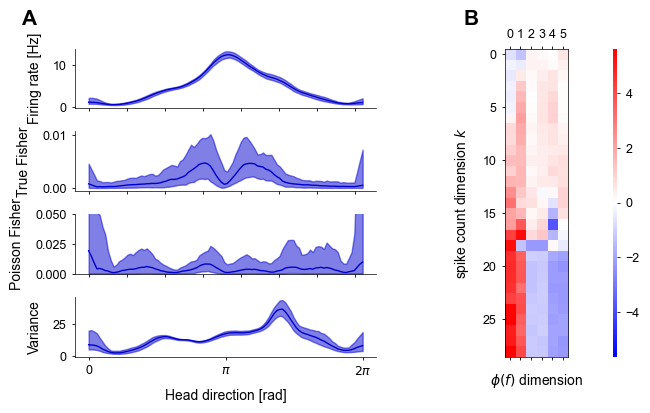

In [12]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(7,4))
colors = ['mediumblue', 'crimson']


gs0 = gridspec.GridSpec(1, 2, fig, wspace=0.4, width_ratios=[2,1])

gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs0[0], hspace=0.4)

ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3])]

line, = ax[0].plot(angles, tc_mean[2, :], color=colors[0])
ax[0].fill_between(
    angles, tc_mean_lower[2, :], tc_mean_upper[2, :], 
    color=line.get_color(), alpha=0.5
)

line, = ax[1].plot(angles, fisher[2, :], color=colors[0])
ax[1].fill_between(
    angles, fisher_lower[2, :], fisher_upper[2, :], 
    color=line.get_color(), alpha=0.5
)

line, = ax[2].plot(angles, fisher_poisson[2, :], color=colors[0])
ax[2].fill_between(
    angles, fisher_poisson_lower[2, :], fisher_poisson_upper[2, :], 
    color=line.get_color(), alpha=0.5
)
ax[2].set_ylim([0, 0.05])

line, = ax[3].plot(angles, tc_var[2, :], color=colors[0])
ax[3].fill_between(
    angles, tc_var_lower[2, :], tc_var_upper[2, :], 
    color=line.get_color(), alpha=0.5
)
ax[0].set_ylabel('Firing rate [Hz]')
ax[1].set_ylabel('True Fisher')
ax[2].set_ylabel('Poisson Fisher')
ax[3].set_ylabel('Variance')

for i in range(3):
    ax[i].set_xticklabels([])

ax[3].set_xticks([0, 180, 360])
ax[3].set_xticklabels(['0', '$\pi$', '$2\pi$'])

ax[3].set_xlabel('Head direction [rad]')


ne = 2  # select neuron
Wn = modelfit.likelihood.mapping_net.mnet.net[0].weight[ne, :, :].data.cpu().numpy()
Wmax = max(-Wn.min(), Wn.max())
widths = [1, 0.03]
heights = [1]

gs = gridspec.GridSpecFromSubplotSpec(ncols=len(widths), nrows=len(heights), subplot_spec=gs0[1], width_ratios=widths, wspace=0.1)

ax = fig.add_subplot(gs[0, 0])
utils.plot.decorate_ax(ax)  # get all four spines around plot
im = ax.matshow(Wn, vmin=-Wmax, vmax=Wmax, cmap=weight_map)
ax.set_xlabel(f'$\phi(f)$ dimension', fontsize=10)
ax.set_ylabel(f'spike count dimension $k$', fontsize=10)

ax = fig.add_subplot(gs[0, 1])
utils.plot.add_colorbar((fig, ax), im, cbar_outline=False, cbar_ori='vertical', cbar_fontsize=12, 
    cbar_pad=20, ticktitle=None, ticks=None, ticklabels=None, cbar_format=None)

fig.text(0.05, 0.94, 'A', transform=fig.transFigure, size=15, fontweight='bold')
fig.text(0.68, 0.94, 'B', transform=fig.transFigure, size=15, fontweight='bold')



fig.savefig("/homes/vn283/UCM-interpret/figures/fisher_validation.pdf", format="pdf", bbox_inches="tight")